# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

### imports and stuff

In [ ]:
%cd drive/MyDrive/Data\ Analysis

/content/drive/MyDrive/Data Analysis


In [ ]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from tqdm.notebook import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 4.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## data preprocessing

### load data

In [ ]:
df = pd.read_csv('data/stock/NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [ ]:
df = df.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
df.head()

,Date,High
0,2002-05-23,1.242857
1,2002-05-24,1.225000
2,2002-05-28,1.232143
3,2002-05-29,1.164286
4,2002-05-30,1.107857


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4945 non-null   object 
 1   High    4945 non-null   float64
dtypes: float64(1), object(1)
memory usage: 77.4+ KB


### resampling

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df = df.set_index(['Date'])
df.sort_index(inplace=True)
df.head()

,High
Date,
2002-05-23,1.242857
2002-05-24,1.225000
2002-05-28,1.232143
2002-05-29,1.164286
2002-05-30,1.107857


In [ ]:
# resample from day- to month-interval
df = df.resample('M').max()
df.head()

,High
Date,
2002-05-31,1.242857
2002-06-30,1.232143
2002-07-31,1.299286
2002-08-31,0.999286
2002-09-30,0.976429


In [ ]:
def plot_price(data, title):
    plt.figure(figsize=(14, 6))
    plt.title(title)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
    data.plot();

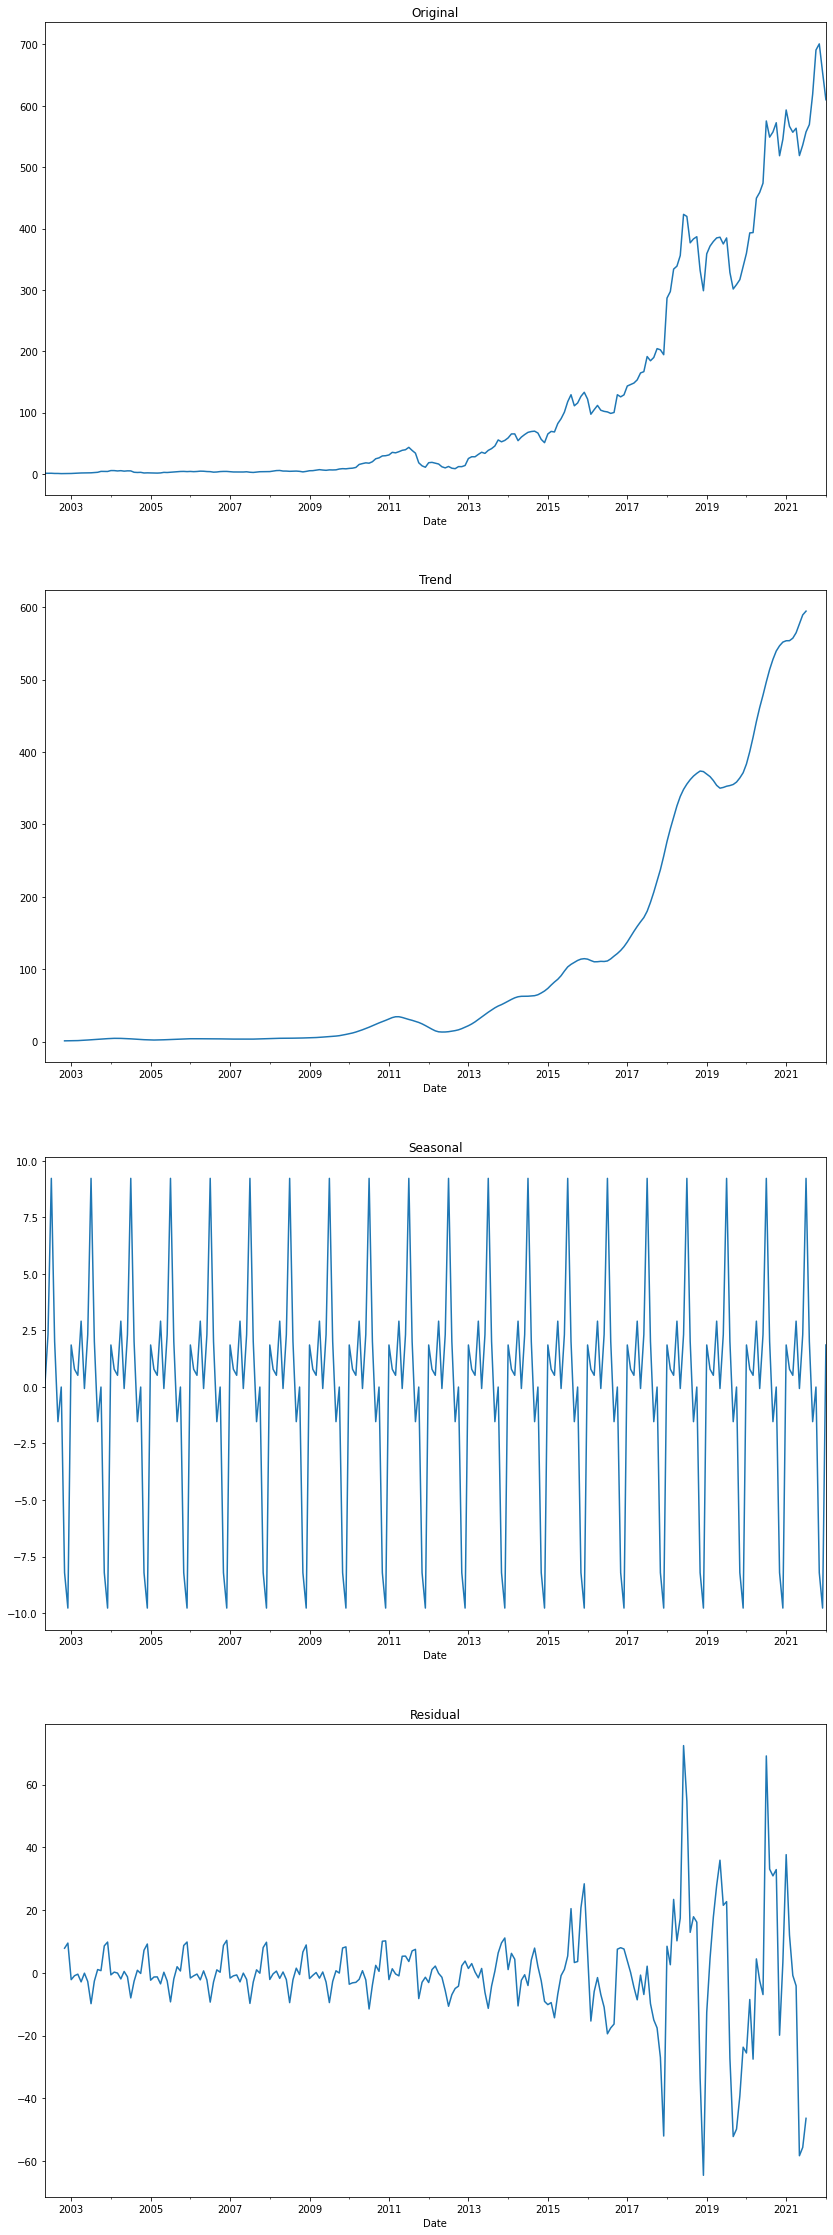

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['High']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

### detrend

#### differencing

In [ ]:
df['HighDiff_1'] = df['High'].diff()
df['HighDiff_12'] = df['High'].diff(periods=12)
df.head()

,High,HighDiff_1,HighDiff_12
Date,,,
2002-05-31,1.242857,NaN,NaN
2002-06-30,1.232143,-0.010714,NaN
2002-07-31,1.299286,0.067143,NaN
2002-08-31,0.999286,-0.300000,NaN
2002-09-30,0.976429,-0.022857,NaN


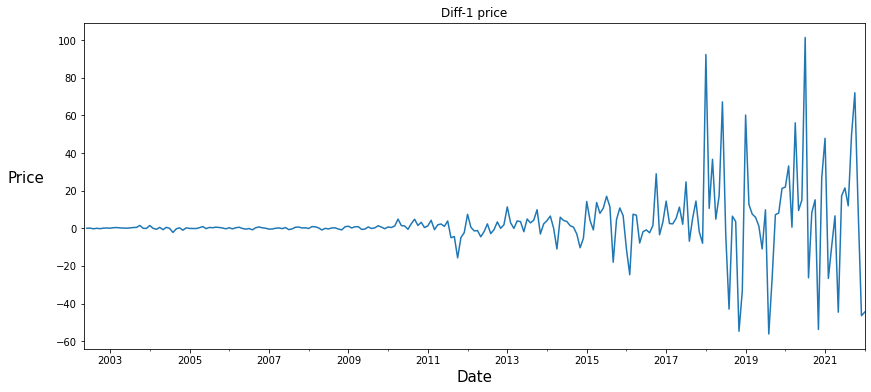

In [ ]:
plot_price(df['HighDiff_1'], 'Diff-1 price')

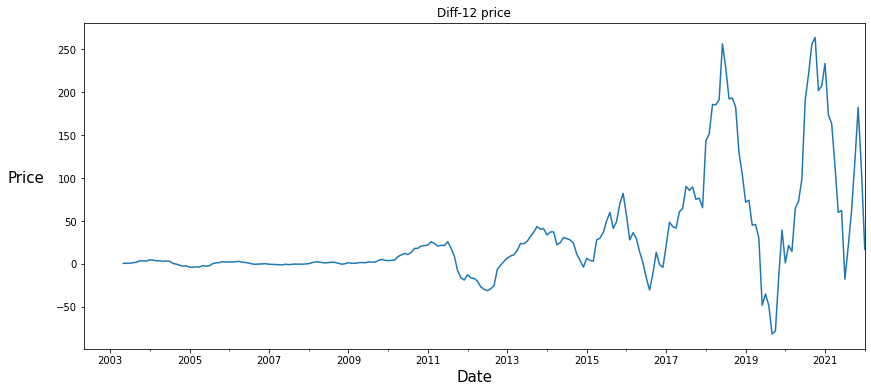

In [ ]:
plot_price(df['HighDiff_12'], 'Diff-12 price')

#### log+differencing

In [ ]:
df = df.drop(['HighDiff_1', 'HighDiff_12'], axis=1)

df['HighLog'] = np.log(df['High'])
df['HighLogDiff_1'] = df['HighLog'].diff()
df['HighLogDiff_12'] = df['HighLog'].diff(periods=12)
df.head()

,High,HighLog,HighLogDiff_1,HighLogDiff_12
Date,,,,
2002-05-31,1.242857,0.217413,NaN,NaN
2002-06-30,1.232143,0.208755,-0.008658,NaN
2002-07-31,1.299286,0.261815,0.053060,NaN
2002-08-31,0.999286,-0.000714,-0.262529,NaN
2002-09-30,0.976429,-0.023853,-0.023139,NaN


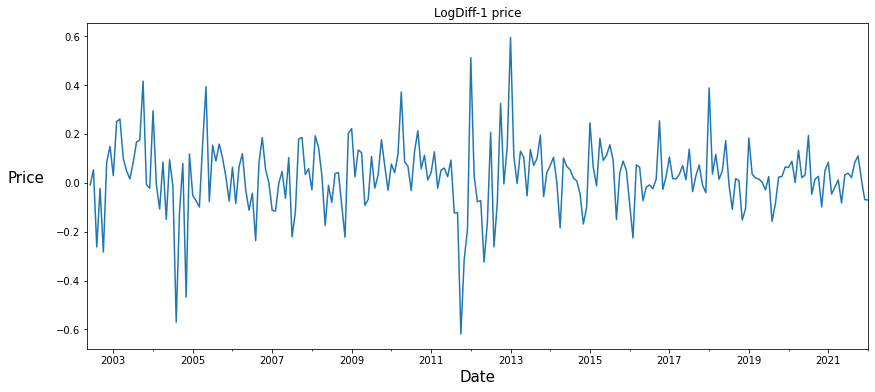

In [ ]:
plot_price(df['HighLogDiff_1'], 'LogDiff-1 price')

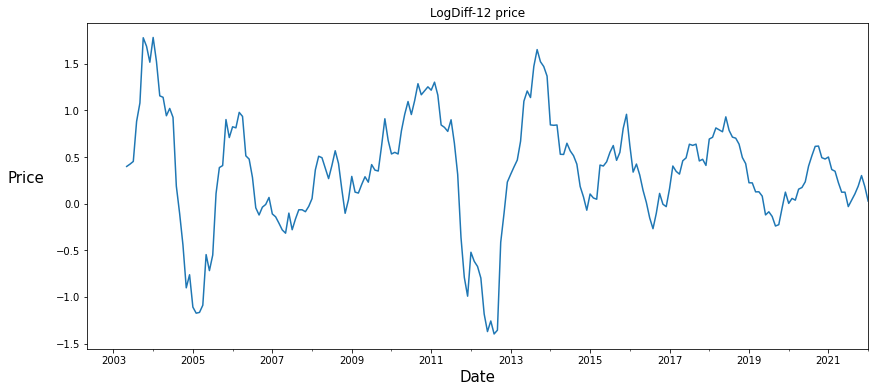

In [ ]:
plot_price(df['HighLogDiff_12'], 'LogDiff-12 price')

### check stationarity

In [ ]:
p_value = adfuller(df['HighLogDiff_1'][1:])[1]

print(f'p-value for LogDiff-1: {round(p_value, 10)}.')

p-value for LogDiff-1: 1.07544e-05.


In [ ]:
p_value = adfuller(df['HighLogDiff_12'][12:])[1]

print(f'p-value for LogDiff-12: {round(p_value, 10)}.')

p-value for LogDiff-12: 0.00312572.


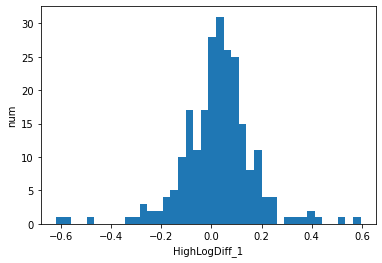

In [ ]:
plt.xlabel('HighLogDiff_1')
plt.ylabel('num')
plt.hist(df['HighLogDiff_1'], bins=40)
plt.show()

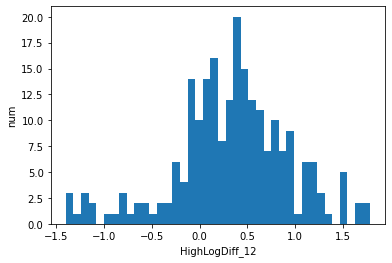

In [ ]:
plt.xlabel('HighLogDiff_12')
plt.ylabel('num')
plt.hist(df['HighLogDiff_12'], bins=40)
plt.show()

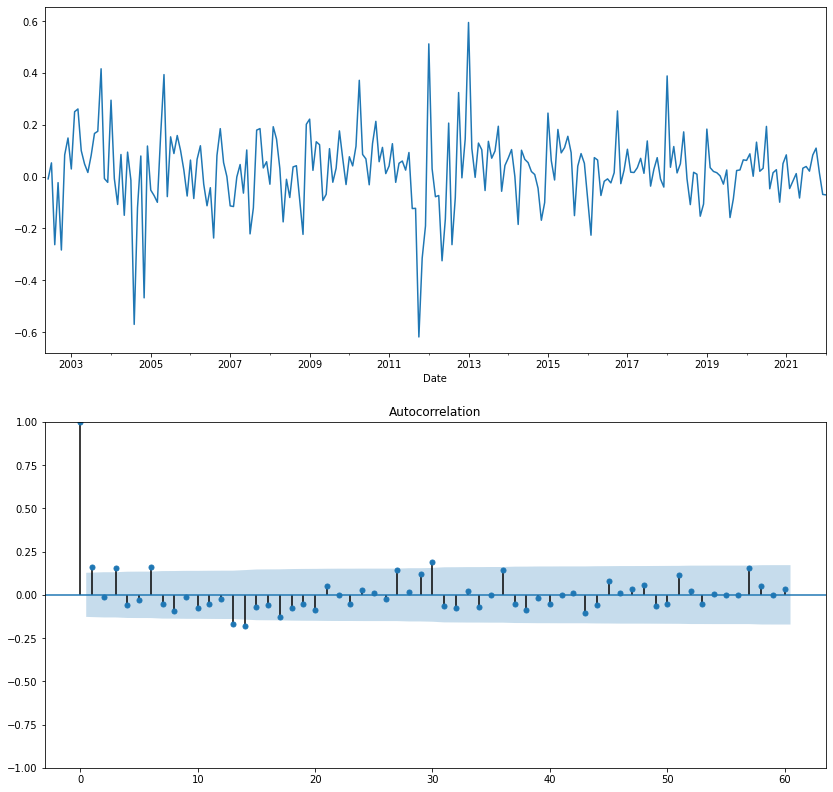

In [ ]:
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df['HighLogDiff_1'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['HighLogDiff_1'][1:], lags=60, ax=ax);

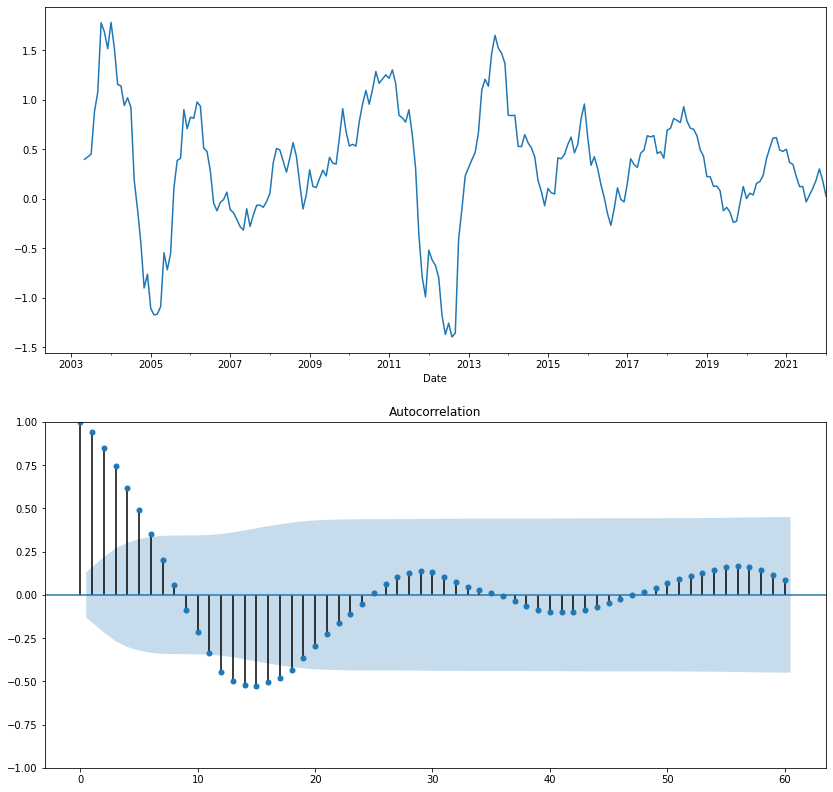

In [ ]:
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
df['HighLogDiff_12'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['HighLogDiff_12'][12:], lags=60, ax=ax);

# Apply SARIMA

### hyperparameters search

In [ ]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [ ]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [ ]:
def apply_SARIMA(data, period, parameters_list):
    length = data.shape[0] - period
    train_length = int(length * 0.8)

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(
                data[period:period+train_length], 
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], 12)
            ).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    return best_model, train_length, results, best_aic, best_param

In [ ]:
import warnings
warnings.filterwarnings("ignore")

best_model_12, train_length_12, results_12, best_aic_12, best_param_12 = apply_SARIMA(
    df['HighLogDiff_12'], 12, parameters_list)

In [ ]:
best_model_1, train_length_1, results_1, best_aic_1, best_param_1 = apply_SARIMA(
    df['HighLogDiff_1'], 1, parameters_list)

### save/load models

In [ ]:
with open('model12.pickle', 'wb') as f:
    pickle.dump((best_model_12, train_length_12, results_12, best_aic_12, best_param_12), f)

In [ ]:
with open('model12.pickle', 'rb') as f:
    best_model_12, train_length_12, results_12, best_aic_12, best_param_12 = pickle.load(f)

In [ ]:
with open('model1.pickle', 'wb') as f:
    pickle.dump((best_model_1, train_length_1, results_1, best_aic_1, best_param_1), f)

In [ ]:
with open('model1.pickle', 'rb') as f:
    best_model_1, train_length_1, results_1, best_aic_1, best_param_1 = pickle.load(f)

### compare models trained with 1-month and 12-months seasonality

In [ ]:
result_table = pd.DataFrame(results_12)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
1   (1, 1, 3, 2) -47.528424
38  (3, 2, 4, 1) -42.540287
0   (1, 1, 3, 1) -42.149821
2   (1, 1, 4, 1) -41.580035
30  (2, 4, 4, 1) -41.382466


In [ ]:
print(best_model_12.summary())

                                        SARIMAX Results                                        
Dep. Variable:                          HighLogDiff_12   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood                  31.764
Date:                                 Sun, 20 Feb 2022   AIC                            -47.528
Time:                                         00:30:29   BIC                            -22.584
Sample:                                     05-31-2003   HQIC                           -37.404
                                          - 04-30-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4202      0.245      1.717      0.086      -0.059       0

In [ ]:
result_table = pd.DataFrame(results_1)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
0   (1, 1, 3, 1) -118.910964
28  (2, 4, 3, 1) -117.173537
2   (1, 1, 4, 1) -116.969229
16  (2, 1, 3, 1) -116.912397
4   (1, 2, 3, 1) -116.789141


In [ ]:
print(best_model_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      HighLogDiff_1   No. Observations:                  188
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                  66.455
Date:                            Sun, 20 Feb 2022   AIC                           -118.911
Time:                                    00:30:32   BIC                            -96.757
Sample:                                06-30-2002   HQIC                          -109.925
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2141      0.083      2.587      0.010       0.052       0.376
ma.L1         -0.9979      0.656   

### plot results

In [ ]:
test_length_12 = df['HighLogDiff_12'].shape[0] - 12 - train_length_12
test_length_1 = df['HighLogDiff_1'].shape[0] - 1 - train_length_1

In [ ]:
df['Predicted_LogDiff_12_train'] = best_model_12.fittedvalues
df['Predicted_LogDiff_12_test'] = best_model_12.predict(
    start=train_length_12, 
    end=train_length_12 + test_length_12 - 1)

df['Predicted_LogDiff_1_train'] = best_model_1.fittedvalues
df['Predicted_LogDiff_1_test'] = best_model_1.predict(
    start=train_length_1, 
    end=train_length_1 + test_length_1 - 1)

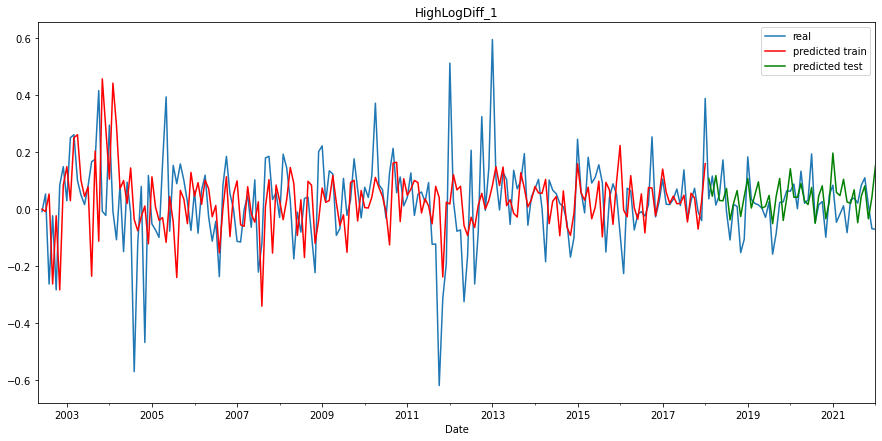

In [ ]:
plt.figure(figsize=(15,7))

df['HighLogDiff_1'].plot(label='real')
df['Predicted_LogDiff_1_train'].plot(c='r', label='predicted train')
df['Predicted_LogDiff_1_test'].plot(c='g', label='predicted test')

plt.title('HighLogDiff_1')
plt.legend()
plt.show()

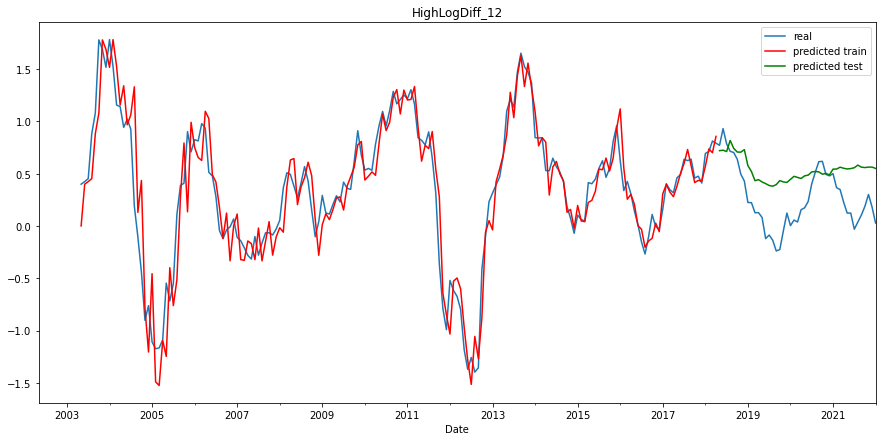

In [ ]:
plt.figure(figsize=(15,7))

df['HighLogDiff_12'].plot(label='real')
df['Predicted_LogDiff_12_train'].plot(c='r', label='predicted train')
df['Predicted_LogDiff_12_test'].plot(c='g', label='predicted test')

plt.title('HighLogDiff_12')
plt.legend()
plt.show()

In [ ]:
def inverse_diff(x_start, x_diff):
    return np.r_[x_start, x_diff].cumsum()

In [ ]:
def inverse_diff_12(x_start, x_diff):
    x = np.r_[x_start, x_diff]
    for i in range(12, x.shape[0]):
        x[i]+=x[i-12]
    return x

In [ ]:
df['Predicted_LogDiff_1'] = df['Predicted_LogDiff_1_train'].combine_first(
    df['Predicted_LogDiff_1_test'])

df['Predicted_1'] = np.exp(inverse_diff(df['HighLog'].iloc[0], 
                                        df['Predicted_LogDiff_1'].iloc[1:]))
df['Predicted_1_train'] = df['Predicted_1'].iloc[:train_length_1 + 1]
df['Predicted_1_test'] = df['Predicted_1'].iloc[train_length_1 + 1:]

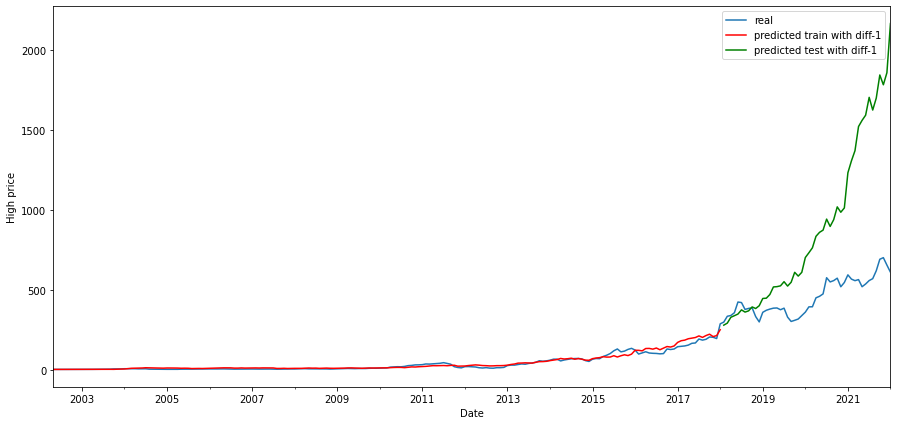

In [ ]:
plt.figure(figsize=(15,7))

df['High'].plot(label='real')
df['Predicted_1_train'].plot(c='r', label='predicted train with diff-1')
df['Predicted_1_test'].plot(c='g', label='predicted test with diff-1')

plt.ylabel('High price')
plt.legend()
plt.show()

In [ ]:
df['Predicted_LogDiff_12'] = df['Predicted_LogDiff_12_train'].combine_first(df['Predicted_LogDiff_12_test'])

df['Predicted_12'] = np.exp(inverse_diff_12(df['HighLog'].iloc[:12], 
                                         df['Predicted_LogDiff_12'].iloc[12:]))
df['Predicted_12_train'] = df['Predicted_12'].iloc[:train_length_12 + 12]
df['Predicted_12_test'] = df['Predicted_12'].iloc[train_length_12 + 12:]

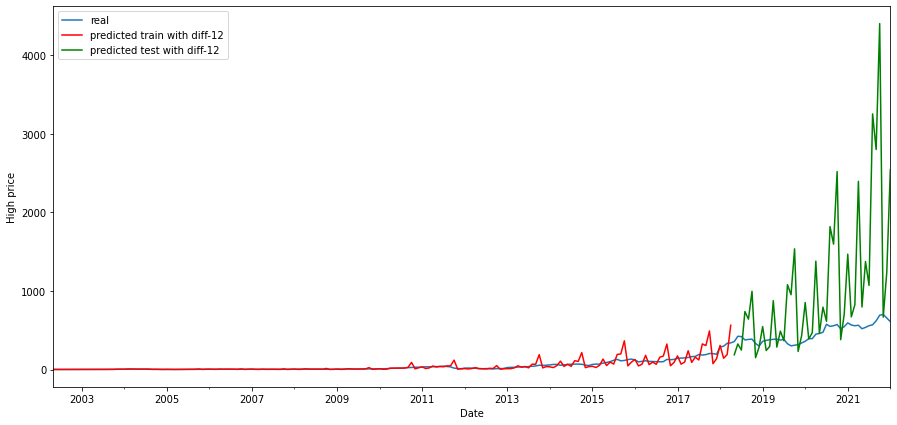

In [ ]:
plt.figure(figsize=(15,7))

df['High'].plot(label='real')
df['Predicted_12_train'].plot(c='r', label='predicted train with diff-12')
df['Predicted_12_test'].plot(c='g', label='predicted test with diff-12')

plt.ylabel('High price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape

print('MAPE on test for LogDiff-1:', 100 * round(mape(df['HighLogDiff_1'][train_length_1 + 1:], 
                                                df['Predicted_LogDiff_1_test'][train_length_1 + 1:]), 2), '%')
print('MAPE on test for original (diff-1)', 100 * round(mape(df['High'][train_length_1 + 1:], 
                                                        df['Predicted_1_test'][train_length_1 + 1:]), 2), '%')

print('MAPE on test for LogDiff-12:', 100 * round(mape(df['HighLogDiff_12'][train_length_12 + 12:], 
                                                df['Predicted_LogDiff_12_test'][train_length_12 + 12:]), 2), '%')
print('MAPE on test for original (diff-12)', 100 * round(mape(df['High'][train_length_12 + 12:], 
                                                        df['Predicted_12_test'][train_length_12 + 12:]), 2), '%')

MAPE on test for LogDiff-1: 241.0 %
MAPE on test for original (diff-1) 83.0 %
MAPE on test for LogDiff-12: 665.0 %
MAPE on test for original (diff-12) 123.0 %
